In [1]:
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [33]:
lista_acoes = ["WEGE3.SA", "LREN3.SA", "VALE3.SA", "PETR4.SA"]
#lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]
precos = pdr.get_data_yahoo(lista_acoes, dt.date(2015, 1, 1), dt.date(2022, 12, 31))['Adj Close']
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna()
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [38]:
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos
    
    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

In [39]:
posicao_sharpe_maximo = vetor_sharpe.argmax()
pesos_otimos = tabela_pesos[posicao_sharpe_maximo, :]
pesos_otimos = [str((peso * 100).round(2)) + "%" for peso in pesos_otimos]

for i, acao in enumerate(lista_acoes):
    print(f"Peso {acao}: {pesos_otimos[i]}")

Peso WEGE3.SA: 63.55%
Peso LREN3.SA: 0.24%
Peso VALE3.SA: 19.21%
Peso PETR4.SA: 17.01%


In [36]:
vetor_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

eixo_y_fronteira_eficiente = np.linspace(vetor_retornos_esperados_arit.min(), 
                                         vetor_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) 
limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    #vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol,peso_inicial,method='SLSQP', bounds=limites, 
                      constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

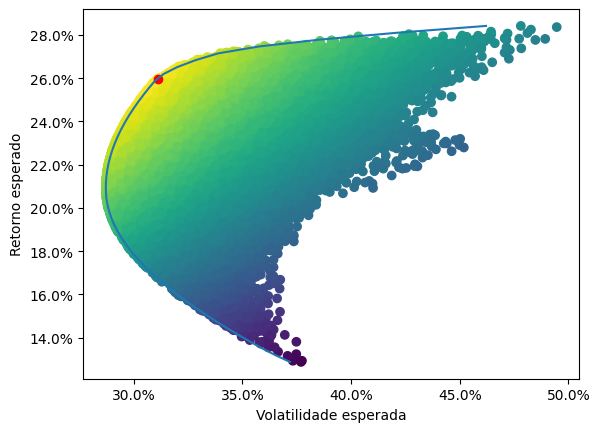

In [37]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, vetor_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[posicao_sharpe_maximo], 
            vetor_retornos_esperados_arit[posicao_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()